# Utils

### Libraries

In [56]:
import pandas as pd
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextlib
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
import umap
import statsmodels.api as sm
import warnings
import sys

In [57]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/data_processing")

In [58]:
import importlib
from data_processing import umap_clustering, umap_regression, clustering_evaluation, umap_run, data_loading

importlib.reload(clustering_evaluation)
importlib.reload(umap_regression)
importlib.reload(umap_clustering)
importlib.reload(umap_run)
importlib.reload(data_loading)

from data_processing.clustering_evaluation import evaluate_kmeans, evaluate_gmm, evaluate_hdbscan, evaluate_consensus
from data_processing.umap_regression import main_regression, plot_ols_diagnostics
from data_processing.umap_clustering import main_clustering
from data_processing.data_loading import main_data_loading

ModuleNotFoundError: spec not found for the module 'data_processing.data_loading'

### Paths and folders

In [4]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'

# Data

## Raw data

#### One file example

In [5]:
# Load an image
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
img = nib.load(path_temp)

# Separate the data and affine
temp_img = img.get_fdata()      # 3D volume data
temp_affine = img.affine        # 4x4 affine matrix

# Print shapes
print(temp_img.shape)
print(temp_affine.shape)

(91, 109, 91)
(4, 4)


#### Load data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [6]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    # Sanity checks
    assert len(files_path) == len(subject_id), (
        f"Mismatch count: {len(files_path)} files vs {len(subject_id)} IDs"
    )
    assert len(subject_id) == len(set(subject_id)), "ID duplicated"
    for fp, sid in zip(files_path, subject_id):
        fname = os.path.basename(fp)
        expected = sid + '.FDC.nii.gz'
        assert fname == expected, (
            f"Filename “{fname}” do not correspond to the extracted ID“{sid}”"
        )

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [7]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  176
Subject:  176


In [8]:
maps_FDC = []
for path in files:
    print(path)
    data = nib.load(path).get_fdata().flatten()
    maps_FDC.append(data)

# Stores subjects as rows and voxels as columns
raw_df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

In [9]:
# Copy without id
df_eda = raw_df.copy()

In [10]:
# Insert subjects id
raw_df.insert(0, 'ID', sub_id)
print("\n", raw_df.shape, "\n")


 (176, 902630) 



Some asserts

In [11]:
# 1Ensure the EDA copy has one row per file
assert df_eda.shape[0] == len(files), (
    f"Rows in df_eda ({df_eda.shape[0]}) != number of files ({len(files)})"
)

# Ensure the raw_df has one row per subject ID
assert raw_df.shape[0] == len(sub_id), (
    f"Number of rows ({raw_df.shape[0]}) != number of IDs ({len(sub_id)})"
)

# Verify the ID column matches the original sub_id order exactly
assert raw_df['ID'].tolist() == sub_id, "Row IDs do not match the original sub_id order"

# Confirm there are no duplicate IDs
assert raw_df['ID'].is_unique, "There are duplicate IDs in the DataFrame"

# Check that inserting the ID column did not alter the numeric data
numeric_equal = (raw_df.drop('ID', axis=1).values == df_eda.values).all()
assert numeric_equal, "Numeric data was altered when inserting the ID column"

#### EDA

In [12]:
print(f"Shape of the dataframe: {df_eda.shape}")

Shape of the dataframe: (176, 902629)


In [13]:
# Global Statistics
all_voxels = df_eda.values.flatten()
all_voxels = all_voxels[~np.isnan(all_voxels)]

# Descriptive statistics
stats_summary = {
    "Min": np.min(all_voxels),
    "Max": np.max(all_voxels),
    "Mean": np.mean(all_voxels),
    "Std": np.std(all_voxels),
    "1st Percentile": np.percentile(all_voxels, 1),
    "25th Percentile": np.percentile(all_voxels, 25),
    "Median (50th)": np.percentile(all_voxels, 50),
    "75th Percentile": np.percentile(all_voxels, 75),
    "99th Percentile": np.percentile(all_voxels, 99),
}

df_stats = pd.DataFrame.from_dict(stats_summary, orient='index', columns=['Value'])
print(df_stats)

                    Value
Min             -0.549580
Max              1.618776
Mean             0.021996
Std              0.056745
1st Percentile  -0.013393
25th Percentile  0.000000
Median (50th)    0.000000
75th Percentile  0.008759
99th Percentile  0.269354


## Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [14]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(cognitive_dataset, sheet_name='Sheet1')
df_meta['Age'] = df_meta['Age'].round(1)

In [15]:
df_meta.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,MMSE
0,002_S_4654,ADNI,F,80.4,18,1.5,27.0
1,002_S_6695,ADNI,M,66.3,18,4.5,25.0
2,003_S_6264,ADNI,M,58.3,12,2.5,23.0
3,003_S_6268,ADNI,M,71.6,20,0.5,29.0
4,003_S_6432,ADNI,F,67.3,18,0.5,30.0


#### EDA on Labels

In [16]:
print("Meta dataset BEFORE removing a subject")
print(df_meta.shape)

# Remove the subject with ID "4_S_5003"
df_meta = df_meta[df_meta['ID'] != '4_S_5003'].reset_index(drop=True)

print("Meta dataset AFTER removing a subject")
print(df_meta.shape)

Meta dataset BEFORE removing a subject
(177, 7)
Meta dataset AFTER removing a subject
(176, 7)


In [60]:
# Saving the new csv
df_meta.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/labels.csv", index=False)

General info

In [17]:
print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         176 non-null    object 
 1   Group      176 non-null    object 
 2   Sex        176 non-null    object 
 3   Age        176 non-null    float64
 4   Education  176 non-null    int64  
 5   CDR_SB     171 non-null    float64
 6   MMSE       168 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.8+ KB
None


Missing values

In [18]:
print("\nMissing values for column:")
print(df_meta.isna().sum())


Missing values for column:
ID           0
Group        0
Sex          0
Age          0
Education    0
CDR_SB       5
MMSE         8
dtype: int64


Unique values WITH NaN

In [19]:
print("\nUnique Values:")
print("Group:", sorted(df_meta['Group'].unique()))
print("CDR_SB:", np.sort(df_meta['CDR_SB'].unique()))
print("MMSE:", np.sort(df_meta['MMSE'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18.   nan]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. nan]


Unique values WITHOUT NaN

In [20]:
cdr_sb_no_nan = df_meta['CDR_SB'].dropna()
mmse_no_nan = df_meta['MMSE'].dropna()

In [21]:
print("\nUnique Values:")
print("CDR_SB:", np.sort(cdr_sb_no_nan.unique()))
print("MMSE:", np.sort(mmse_no_nan.unique()))


Unique Values:
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18. ]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30.]


In [22]:
print(df_meta.select_dtypes(include='number').describe().round(1))

         Age  Education  CDR_SB   MMSE
count  176.0      176.0   171.0  168.0
mean    70.9       15.8     4.1   24.1
std      8.4        3.5     3.4    5.0
min     53.0        2.0     0.0    4.0
25%     64.0       14.0     1.5   22.0
50%     71.2       16.0     3.5   25.0
75%     76.0       18.0     6.0   28.0
max     93.8       27.0    18.0   30.0


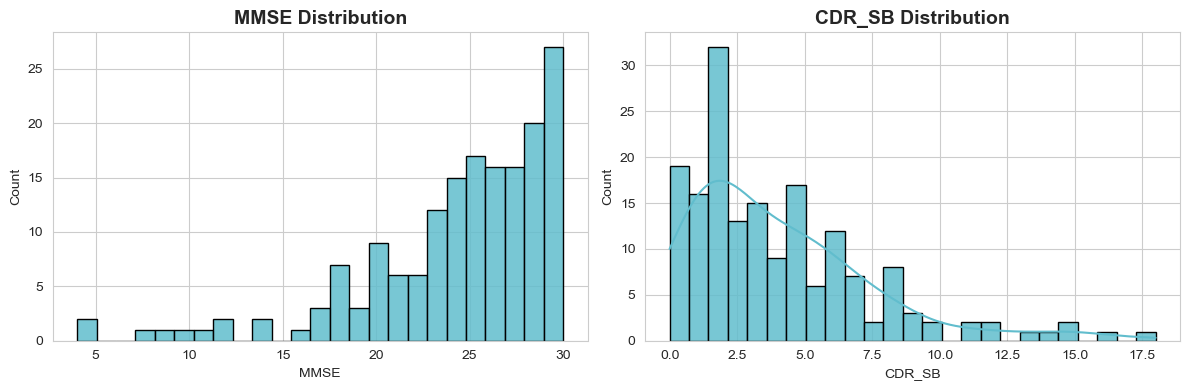

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(mmse_no_nan, bins=25, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.85)
axes[0].set_title("MMSE Distribution", fontsize=14, weight='bold')

sns.histplot(cdr_sb_no_nan, bins=25, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.85, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

#### GMM on CDR_SB

Assigning each CDB_SB value to a cluster using GMM, removing NaN values before

In [24]:
# Filter valid CDR_SB values
df_cdr = df_meta[['ID', 'CDR_SB']].dropna().copy()
print("Dimensions after dropping NaN", df_cdr.shape)

# Fit GMM and predict raw labels
np.random.seed(42)
x_gmm = df_cdr['CDR_SB'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42).fit(x_gmm)
df_cdr['GMM_Label'] = gmm.predict(x_gmm)

# Reorder labels by CDR_SB severity
means = df_cdr.groupby('GMM_Label')['CDR_SB'].mean().sort_values()
label_map = {old: new for new, old in enumerate(means.index)}
df_cdr['GMM_Label'] = df_cdr['GMM_Label'].map(label_map)

# Include in metadata
label_map = dict(zip(df_cdr['ID'], df_cdr['GMM_Label']))
df_meta = df_meta.drop(columns=['GMM_Label'], errors='ignore')
df_meta['GMM_Label'] = df_meta['ID'].map(label_map).astype('Int64')

Dimensions after dropping NaN (171, 2)


In [25]:
print(df_meta['GMM_Label'].value_counts().sort_index())

GMM_Label
0    80
1    76
2    15
Name: count, dtype: Int64


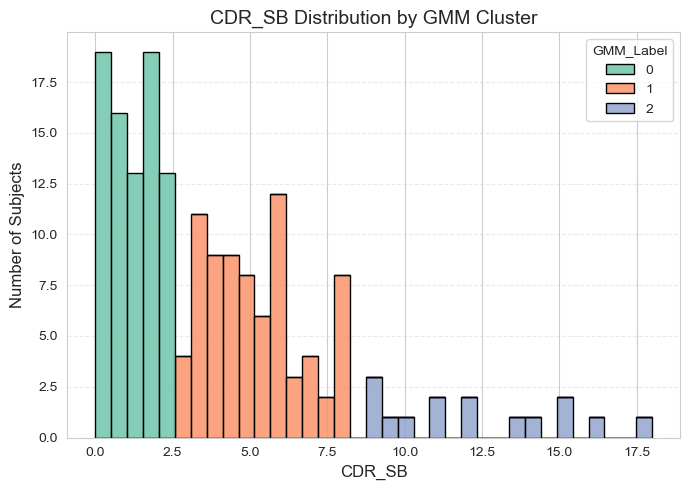

In [26]:
plt.figure(figsize=(7, 5))
sns.histplot(
    data=df_meta.dropna(subset=['CDR_SB', 'GMM_Label']),
    x='CDR_SB',
    hue='GMM_Label',
    palette='Set2',
    multiple='stack',   # oppure 'dodge' per barre affiancate
    bins=35,
    edgecolor='black',
    alpha=0.8
)

plt.xlabel("CDR_SB", fontsize=12)
plt.ylabel("Number of Subjects", fontsize=12)
plt.title("CDR_SB Distribution by GMM Cluster", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

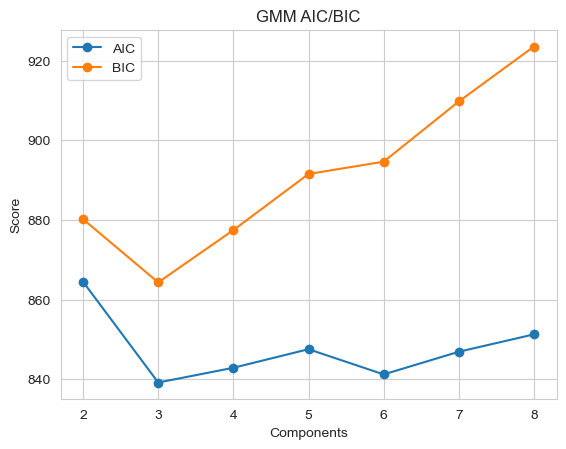

In [27]:
aic, bic = evaluate_gmm(x_gmm, K_range=range(2, 9), save_path= None, prefix="cdr_sb", plot_flag=True)

# Analysis with UMAP

## Data

### Load data

Recall the dataframe with ID and values of the maps

In [28]:
print("\n", raw_df.shape, "\n")
raw_df.iloc[:5, :5]


 (176, 902630) 



,ID,0,1,2,3
0,002_S_4654,0.0,0.0,0.0,0.0
1,002_S_6695,0.0,0.0,0.0,0.0
2,003_S_6264,0.0,0.0,0.0,0.0
3,003_S_6268,0.0,0.0,0.0,0.0
4,003_S_6432,0.0,0.0,0.0,0.0


Merging the meta columns with the above dataframe: the order of the subject must be the same of the dataframe of the FC maps

In [29]:
df_meta = df_meta.set_index('ID').loc[raw_df['ID']].reset_index()

assert all(raw_df['ID'] == df_meta['ID']), "Mismatch between ID of df and df_meta_ordered"
print("The ID are now perfectly aligned")

The ID are now perfectly aligned


### Preprocessing

#### Removing NaN subjects

Removing the subjects with NaN values in the target column
- or CDR_SB
- or MMSE

In [30]:
# Copy for safety
df = raw_df.copy()

# Target column
target_col = 'CDR_SB'

# Removing NaN subjects
print(f"Recall rows with missing {target_col}:", df_meta[target_col].isna().sum())
subjects_nan = df_meta[df_meta[target_col].isna()]['ID'].tolist()
print(f"Subject with missing {target_col}:", subjects_nan)

Recall rows with missing CDR_SB: 5
Subject with missing CDR_SB: ['1_S_5052', '1_S_5096', '1_S_5097', '1_S_5101', '4_S_5008']


In [31]:
df = df[~df['ID'].isin(subjects_nan)].reset_index(drop=True)
print("New dimension of df:", df.shape)

New dimension of df: (171, 902630)


#### Thresholding

Set a threshold for values below 0.1 and 0.2 for defining correlation

In [32]:
def apply_threshold(dataframe, threshold):
    df_thr = dataframe.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [33]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [34]:
df_thr_02 = apply_threshold(df, threshold=0.2)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [35]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframe
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [36]:
# GM masking
# 0.1 threshold
df_thr01_gm_masked = apply_mask(df_thr_01, gm_mask_path)

# 0.2 threshold
df_thr02_gm_masked = apply_mask(df_thr_02, gm_mask_path)

# Without threshold
df_gm_masked = apply_mask(df, gm_mask_path)

In [37]:
# Harvard masking
# 0.1 threshold
df_thr01_har_masked = apply_mask(df_thr_01, harvard_oxford_mask_path)

# 0.2 threshold
df_thr02_har_masked = apply_mask(df_thr_02, harvard_oxford_mask_path)

# Without
df_har_masked = apply_mask(df, harvard_oxford_mask_path)

### EDA

In [38]:
print("Dimensions of dataframes after gm masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_gm_masked.shape)
print("0.2 threshold", df_thr02_gm_masked.shape)

print("\nDimensions of dataframes after harvard masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_har_masked.shape)
print("0.2 threshold", df_thr02_har_masked.shape)

print("\nDimensions of dataframes after gm masking and harvard masking without thresholding:")
print("GM Mask", df_gm_masked.shape)
print("Harvard Mask", df_har_masked.shape)

Dimensions of dataframes after gm masking with 2 different thresholds:
0.1 threshold (171, 161818)
0.2 threshold (171, 161818)

Dimensions of dataframes after harvard masking with 2 different thresholds:
0.1 threshold (171, 55005)
0.2 threshold (171, 55005)

Dimensions of dataframes after gm masking and harvard masking without thresholding:
GM Mask (171, 161818)
Harvard Mask (171, 55005)


In [39]:
def summarize_voxel_data(df_masked, threshold=None):
    summary = {}
    summary['Shape'] = df_masked.shape

    if threshold:
        has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
        summary['Valori tra 0 e threshold'] = has_low
    else:
        summary['Valori tra 0 e threshold'] = 'N/A'

    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    summary['Zero maps'] = f"{zero_rows} su {df_masked.shape[0]}"

    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    summary['All Min'] = voxel_data.min()
    summary['All Max'] = voxel_data.max()
    summary['All Mean'] = voxel_data.mean()
    summary['All Std'] = voxel_data.std()

    summary['Nonzero Min'] = nonzero_voxels.min()
    summary['Nonzero Max'] = nonzero_voxels.max()
    summary['Nonzero Mean'] = nonzero_voxels.mean()
    summary['Nonzero Std'] = nonzero_voxels.std()

    return summary

In [40]:
# Dataset
dataframes = {
    "thr_01_gm": (df_thr01_gm_masked, 0.1),
    "thr_02_gm": (df_thr02_gm_masked, 0.2),
    "thr_01_har": (df_thr01_har_masked, 0.1),
    "thr_02_har": (df_thr02_har_masked, 0.2),
    "gm_no_thr": (df_gm_masked, None),
    "har_no_thr": (df_har_masked, None)
}

# Functions
results = []

for name, (dfm, thr) in dataframes.items():
    summary = summarize_voxel_data(dfm, threshold=thr)
    summary['Dataset'] = name
    results.append(summary)

# Summary
df_summary = pd.DataFrame(results).set_index('Dataset')
pd.options.display.float_format = '{:.4f}'.format

In [41]:
print("Summary of voxel data:")
display(df_summary)

Summary of voxel data:


,Shape,Valori tra 0 e threshold,Zero maps,All Min,All Max,All Mean,All Std,Nonzero Min,Nonzero Max,Nonzero Mean,Nonzero Std
Dataset,,,,,,,,,,,
thr_01_gm,"(171, 161818)",False,0 su 171,0.0000,1.6188,0.0734,0.1020,0.1000,1.6188,0.1829,0.0767
thr_02_gm,"(171, 161818)",False,0 su 171,0.0000,1.6188,0.0342,0.0941,0.2000,1.6188,0.2746,0.0708
thr_01_har,"(171, 55005)",False,0 su 171,0.0000,1.6188,0.0844,0.1068,0.1000,1.6188,0.1867,0.0781
thr_02_har,"(171, 55005)",False,8 su 171,0.0000,1.6188,0.0412,0.1020,0.2000,1.6188,0.2751,0.0719
gm_no_thr,"(171, 161818)",N/A,0 su 171,-0.2879,1.6188,0.0997,0.0870,-0.2879,1.6188,0.0997,0.0870
har_no_thr,"(171, 55005)",N/A,0 su 171,-0.1555,1.6188,0.1084,0.0916,-0.1555,1.6188,0.1084,0.0916


### Input Data

For the further analysis we will remove the ID labels columns, but the order is mantained.

Possible dataset:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Here we go with one example

In [42]:
def features_merging(df_voxel, df_labels):
    # Meta columns
    meta_columns = list(df_labels.columns)

    # Merge based on subject ID
    dataframe_merge = pd.merge(df_voxel, df_labels, on='ID', how='left', validate='one_to_one')

    # Reorder columns: metadata first, then voxel features
    ordered_cols = meta_columns + [col for col in dataframe_merge.columns if col not in meta_columns]
    dataframe_merge = dataframe_merge[ordered_cols]

    # Sanity check to ensure row alignment
    assert (dataframe_merge['ID'].values == df_voxel['ID'].values).all(), "Row order mismatch after merge"

    # Extract features only (drop metadata)
    x = dataframe_merge.drop(columns=meta_columns)

    return dataframe_merge, x

In [43]:
df_merged, X = features_merging(df_thr02_har_masked, df_meta)

In [44]:
X.shape

(171, 55004)

## Dimensionality Reduction

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [45]:
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}

In [46]:
# Parameters
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap = reducer.fit_transform(X)

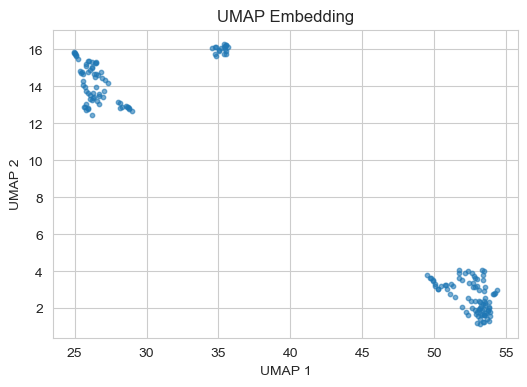

In [47]:
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

## Unsupervised Clustering

### Optimal number of clusters

Optimal number of clusters

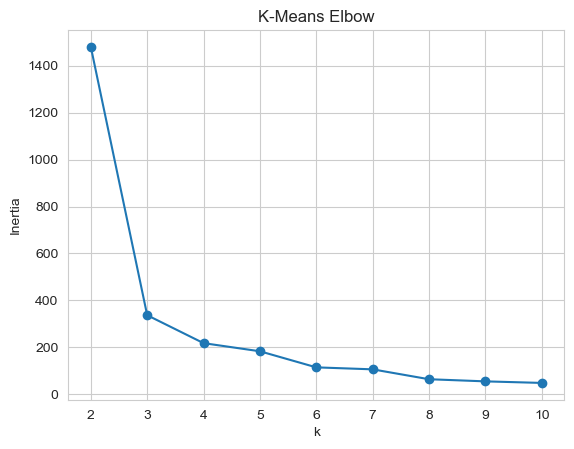

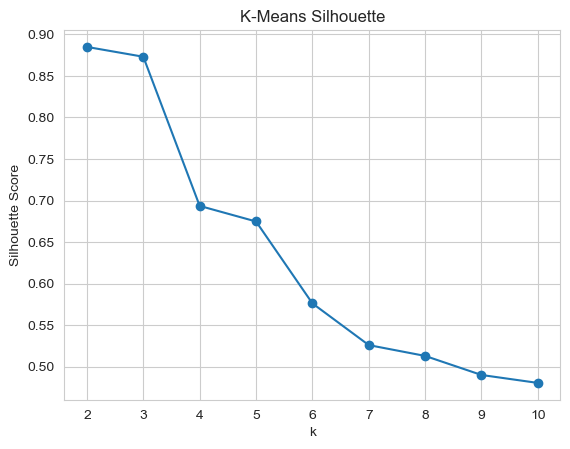

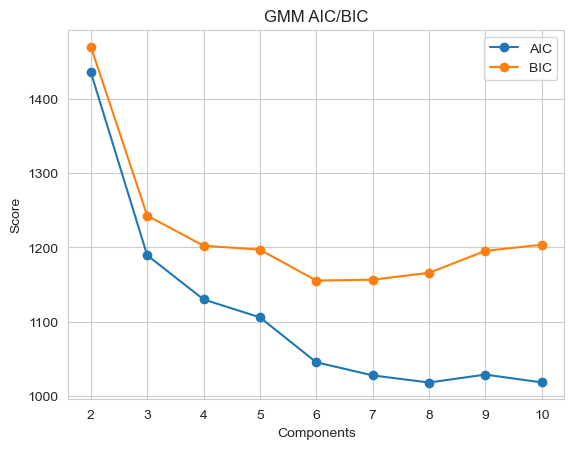

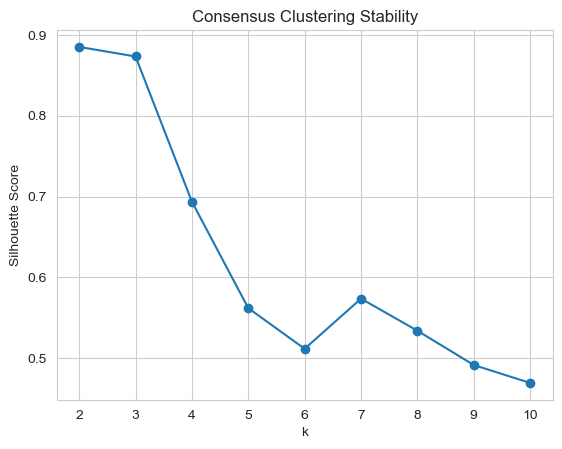

In [49]:
# K-Means optimal clusters
inertias, sil_scores = evaluate_kmeans(
    X_umap,
    K_range=range(2, 11),
    save_path=None,
    prefix= "gm02",
    plot_flag=True
)

# GMM optimal clusters
aic, bic = evaluate_gmm(
    X_umap,
    K_range=range(2, 11),
    save_path=None,
    prefix="gm02",
    plot_flag=True
)

# Consenus clustering
stability_scores = evaluate_consensus(
    X_umap,
    K_range=range(2, 11),
    n_runs=100,
    save_path=None,
    prefix='gm02',
    plot_flag=True
)

In [50]:
# HDBSCAN optimal clusters
labels_hdb, n_hdb = evaluate_hdbscan(X_umap, min_cluster_size=5)

HDBSCAN found 6 clusters (excluding noise)


### Fit models

In [51]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

Result collection

In [52]:
labels_dict = {
    "HDBSCAN": labels_hdb,
    "DBSCAN": labels_db,
    "K-Means": labels_km,
    "GMM": labels_gmm
}

In [53]:
'''
labels_df = pd.DataFrame({
    'ID': df_merged['ID'],
    'HDBSCAN': labels_hdb,
    'DBSCAN': labels_db,
    'KMeans': labels_km,
    'GMM': labels_gmm
})

labels_df.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/clustering_labels_by_ID.csv", index=False)
'''

'\nlabels_df = pd.DataFrame({\n    \'ID\': df_merged[\'ID\'],\n    \'HDBSCAN\': labels_hdb,\n    \'DBSCAN\': labels_db,\n    \'KMeans\': labels_km,\n    \'GMM\': labels_gmm\n})\n\nlabels_df.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/clustering_labels_by_ID.csv", index=False)\n'

### Plotting

In [54]:
def plot_clusters_vs_labels(x_umap, labels_dictionary, label_source_df, label_column, figsize=(16, 24), margin=5):
    n = len(labels_dictionary)
    n_cols = 2
    n_rows = n

    x_min, x_max = x_umap[:, 0].min() - margin, x_umap[:, 0].max() + margin
    y_min, y_max = x_umap[:, 1].min() - margin, x_umap[:, 1].max() + margin

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, (title, labels) in enumerate(labels_dictionary.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        plot_df = pd.DataFrame({
            'X1': x_umap[:, 0],
            'X2': x_umap[:, 1],
            'cluster': labels,
            'label': label_source_df[label_column].reset_index(drop=True)
        })

        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='label', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - {label_column}')
        ax_right.set_xlim(x_min, x_max)
        ax_right.set_ylim(y_min, y_max)
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

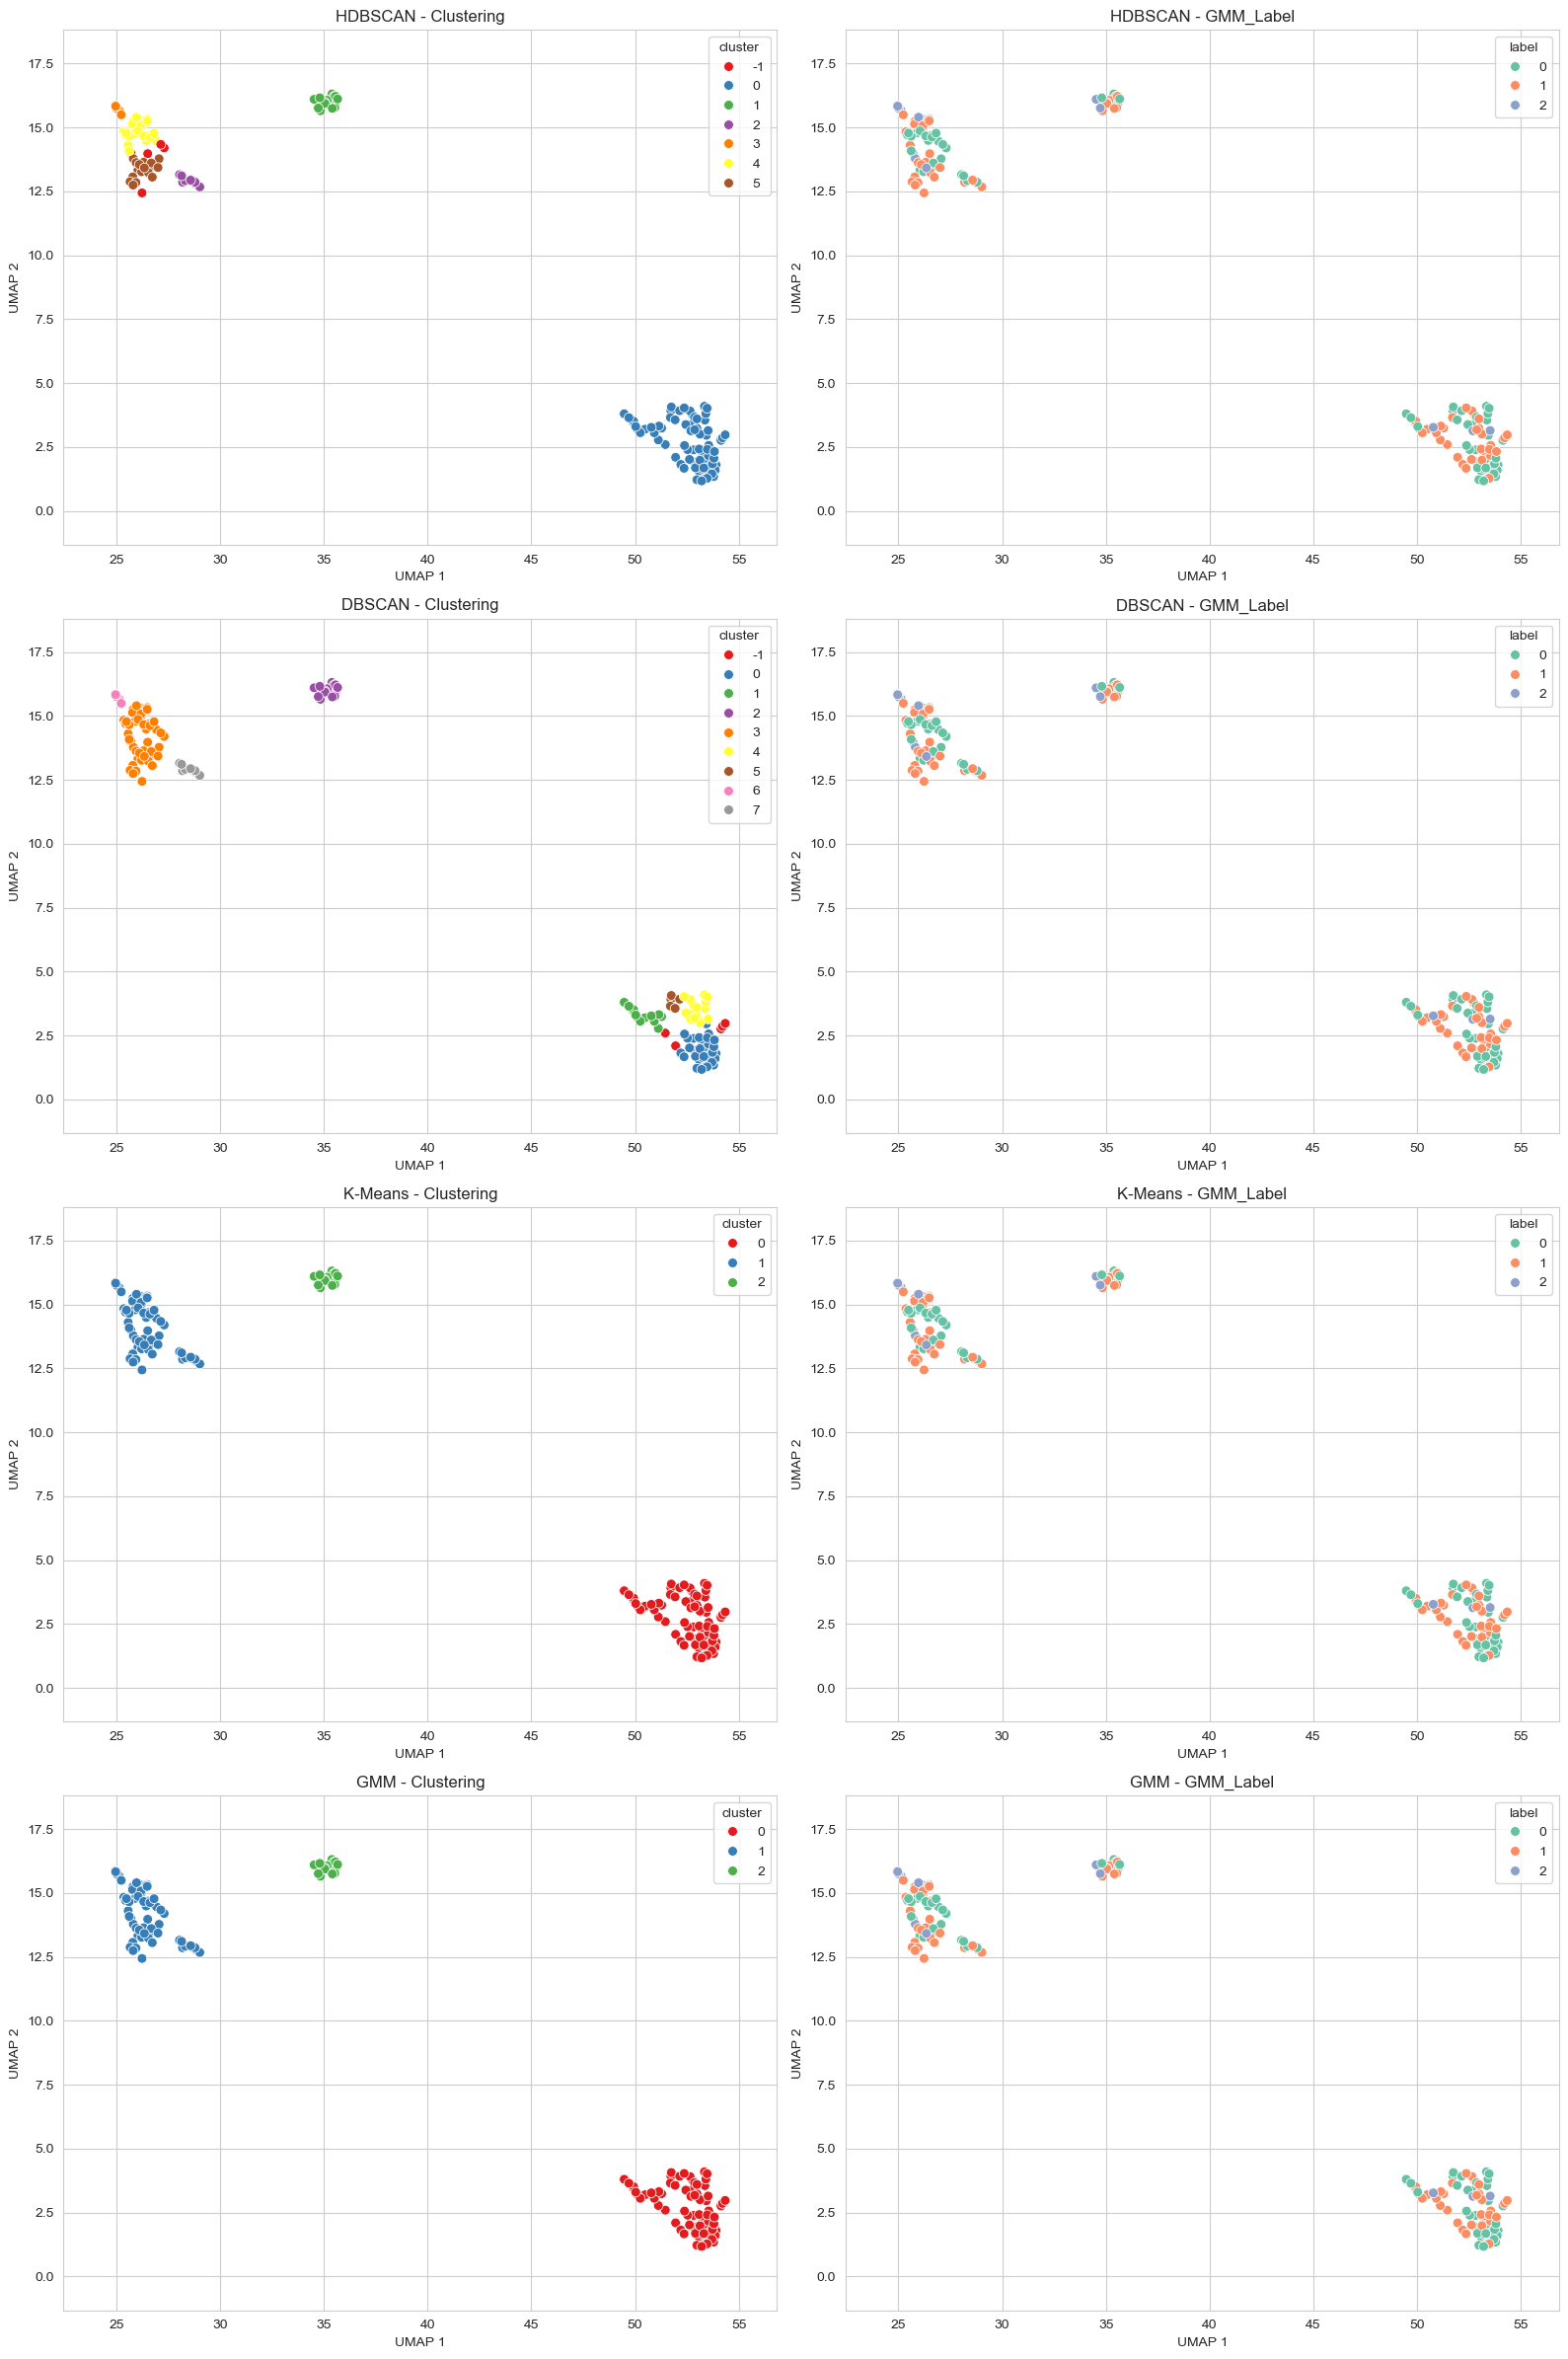

In [55]:
plot_clusters_vs_labels(X_umap, labels_dict, df_merged, label_column='GMM_Label', margin=2.5)

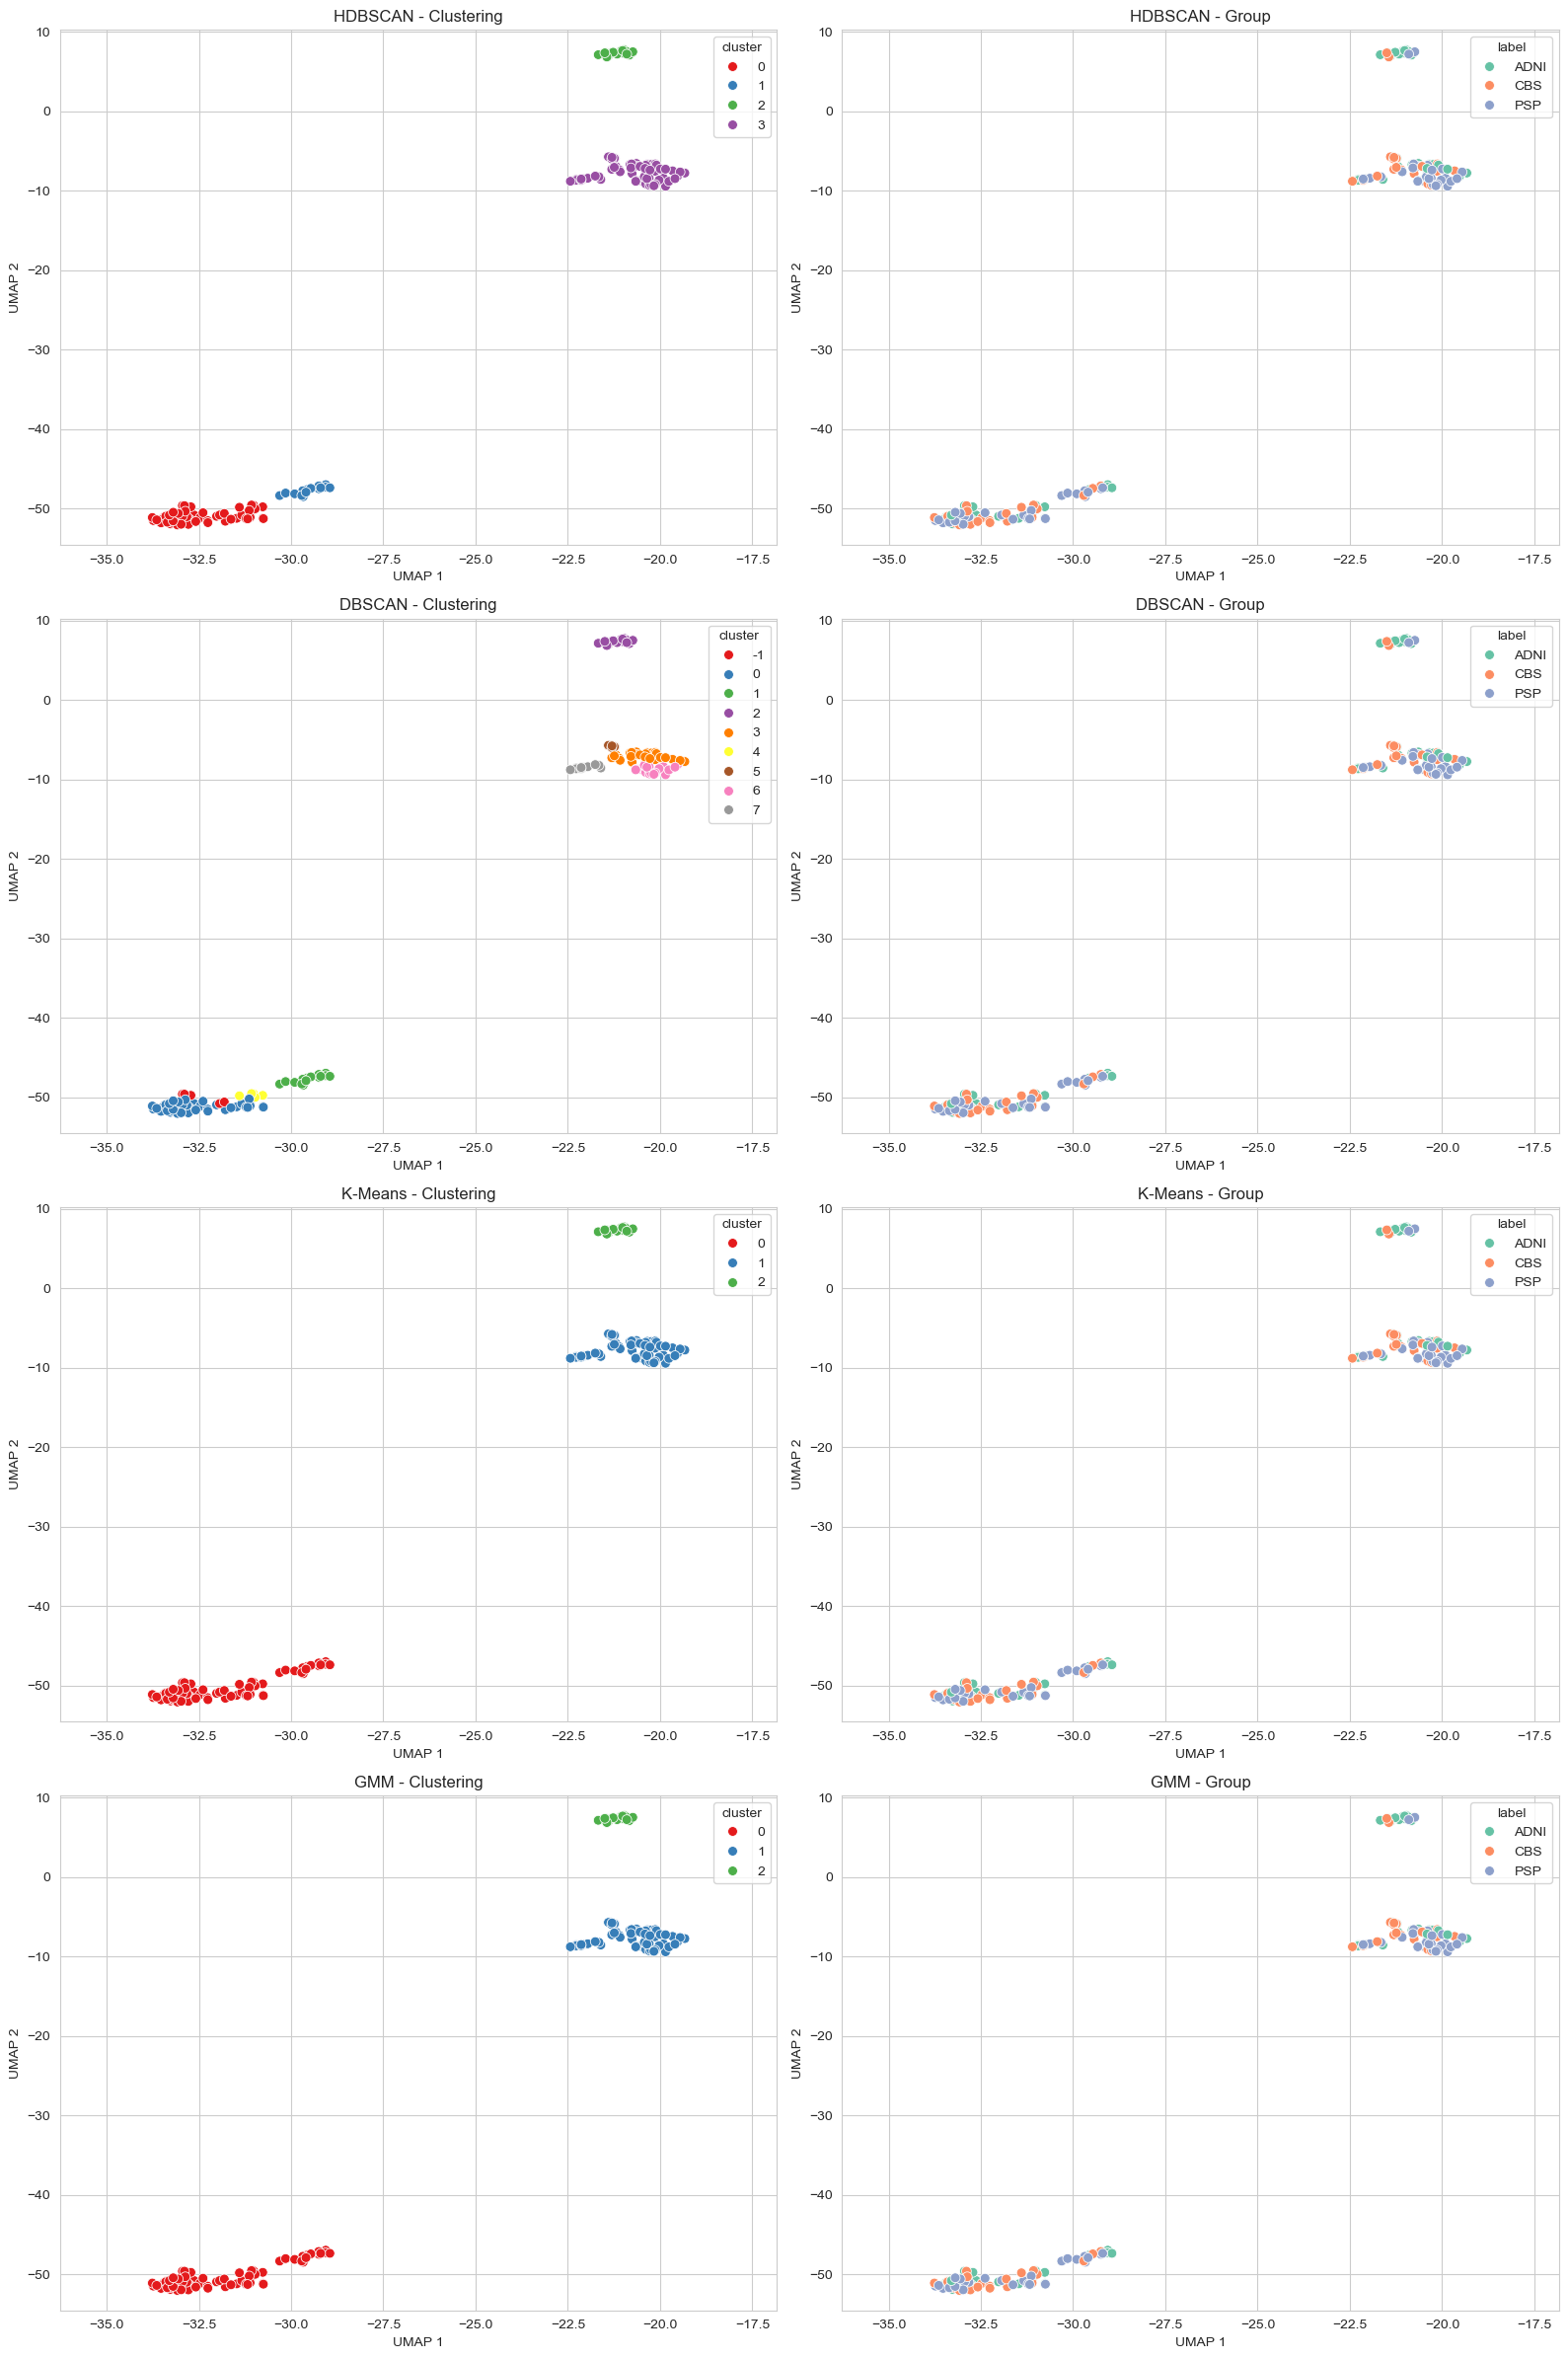

In [181]:
plot_clusters_vs_labels(X_umap, labels_dict, df_merged, label_column='Group', margin=2.5)

## Linear Regression

### Example
- OLS
- Plot
- Shuffling

Input and target definition

In [183]:
# Features
df_merged, X = features_merging(df_gm_masked, df_meta)
reducer = umap.UMAP(**umap_params)
X_umap = reducer.fit_transform(X)

# Target
y = df_merged[target_col]

# Add constant (intercept)
X_with_const = sm.add_constant(X_umap)

# Fit OLS
model = sm.OLS(y, X_with_const).fit()

# Predictions and residuals
y_pred = model.predict(X_with_const)
residuals = y - y_pred

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     9.269
Date:                Wed, 28 May 2025   Prob (F-statistic):           0.000153
Time:                        11:39:26   Log-Likelihood:                -500.37
No. Observations:                 168   AIC:                             1007.
Df Residuals:                     165   BIC:                             1016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4675      3.199      3.272      0.0

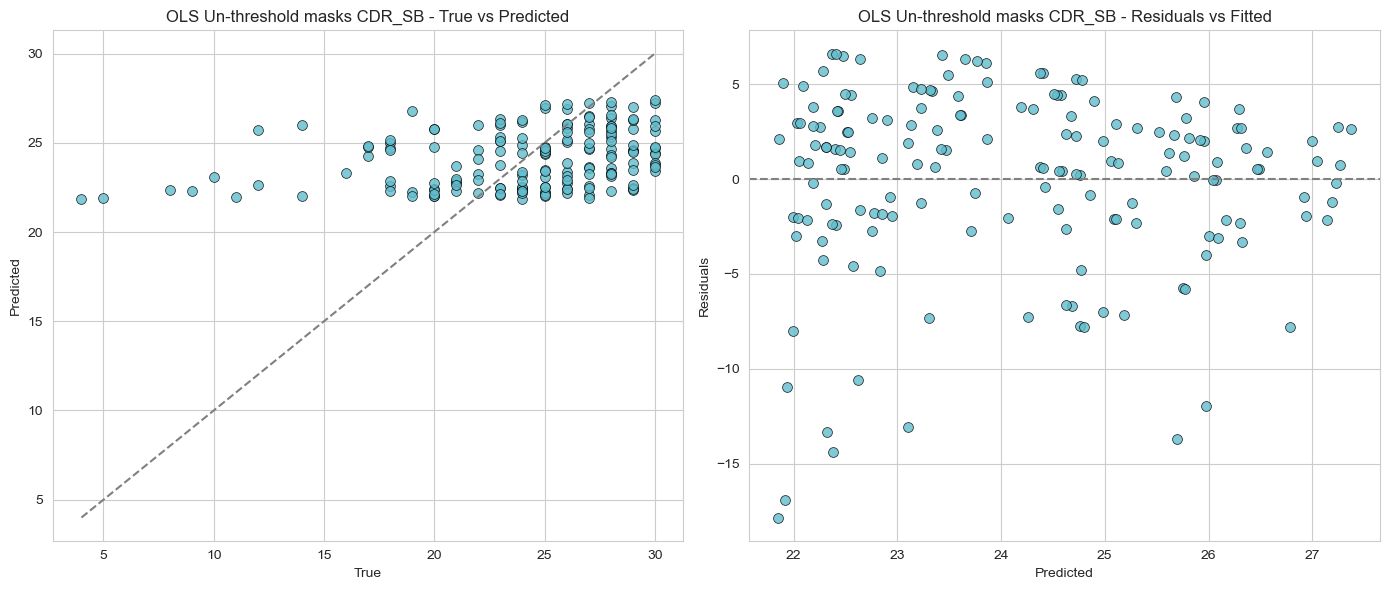

In [184]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Un-threshold masks CDR_SB",save_path=None, plot_flag=True)

Shuffling Regression

In [185]:
# R² real
r2_real = model.rsquared

# List of R² after shuffling
r2_shuffled = []

for _ in range(100):
    y_shuffled = y.sample(frac=1, replace=False, random_state=None).reset_index(drop=True)
    model_shuffled = sm.OLS(y_shuffled, X_with_const).fit()
    r2_shuffled.append(model_shuffled.rsquared)

# empiric p-value
p_value = np.mean([r >= r2_real for r in r2_shuffled])

print(f"R² real: {r2_real:.4f}")
print(f"R² shuffled: {np.mean(r2_shuffled):.4f}")
print(f"p-value (shuffling): {p_value:.4f}")

R² real: 0.1010
R² shuffled: 0.0135
p-value (shuffling): 0.0000


### GMM distributions

In [135]:
for gmmLabel in range(0,3):
    mean_cdr = df_meta.loc[df_meta['GMM_Label'] == gmmLabel, 'CDR_SB'].mean()
    print(f"Media CDR_SB per gruppo {gmmLabel}: {mean_cdr:.3f}")

Media CDR_SB per gruppo 0: 1.406
Media CDR_SB per gruppo 1: 5.386
Media CDR_SB per gruppo 2: 13.000


In [143]:
# Select the subjects ID with a particular GMM_Label
gmm_ids = df_meta[df_meta['GMM_Label'] == 0]['ID']

# Filter the dataset
df_features = df_thr02_har_masked.copy()

df_masked_gmm = df_features[df_features['ID'].isin(gmm_ids)].reset_index(drop=True)
df_meta_gmm = df_meta[df_meta['ID'].isin(gmm_ids)].reset_index(drop=True)

In [ ]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_masked_gmm,
    df_meta = df_meta_gmm,
    target_variable = "CDR_SB",
    covariates = None,
    y_log_transform = False,
    plot_flag = False,
    save_path = None,
    title_prefix = "gm_mask_GMM"
)

# CNN

## Data

### Loading

In [62]:
# Set paths
file_name = "1_S_5005.FDC.nii.gz"

# Load raw image
path_temp = os.path.join(dir_FCmaps, file_name)
img = nib.load(path_temp)
data_raw = img.get_fdata()
affine = img.affine

### Pre-processing

In [63]:
# Load GM mask
mask = nib.load(gm_mask_path).get_fdata()
mask = mask != 0

# Parameters
threshold = 0.1
apply_normalization = True

# Threshold
data_proc = np.copy(data_raw)
data_proc[data_proc < threshold] = 0

# Masking
data_proc[~mask] = 0

# Normalization
if apply_normalization:
    nonzero = data_proc[data_proc != 0]
    if nonzero.size > 0:
        min_val = nonzero.min()
        max_val = nonzero.max()
        if max_val != min_val:
            data_proc[data_proc != 0] = (data_proc[data_proc != 0] - min_val) / (max_val - min_val)

In [64]:
# Output path
out_dir = "/Users/emmatosato/Documents/PhD/ANM_Verona"
base_name = file_name.replace('.nii.gz', '')

raw_save_path = os.path.join(out_dir, f"{base_name}.raw.nii.gz")
nii_save_path = os.path.join(out_dir, f"{base_name}.processed01.nii.gz")

# Save as .nii.gz
raw_img = nib.Nifti1Image(data_raw, affine)
nib.save(raw_img, raw_save_path)

proc_img = nib.Nifti1Image(data_proc, affine)
nib.save(proc_img, nii_save_path)

## Analysis

Example of comparison between the raw and processed images

In [75]:
# --- Paths ---
raw_map_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/1_S_5005.FDC.raw.nii.gz'
processed_map_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/1_S_5005.FDC.processed02.nii.gz'

# --- Load the NIfTI files ---
raw_img = nib.load(raw_map_path).get_fdata()
processed_img = nib.load(processed_map_path).get_fdata()

# --- Flatten the images ---
raw_flat = raw_img.flatten()
processed_flat = processed_img.flatten()

In [82]:
# --- Compare voxels ---
# 1. Absolute difference
abs_diff = np.abs(raw_flat - processed_flat)

# 2. Mean absolute difference
mean_abs_diff = abs_diff.mean()

# 3. Percentage of voxels that changed
changed_voxels = abs_diff > 1e-6  # Mask of changed voxels
num_changed_voxels = np.sum(changed_voxels)
total_voxels = raw_flat.shape[0]
percentage_changed = (num_changed_voxels / total_voxels) * 100

# 4. Among changed voxels, percentage that became zero
changed_and_now_zero = (processed_flat[changed_voxels] == 0)
percentage_changed_to_zero = (np.sum(changed_and_now_zero) / num_changed_voxels) * 100

In [83]:
# --- Print results ---
print(f"Mean absolute difference: {mean_abs_diff:.6f}")
print(f"Percentage of voxels changed: {percentage_changed:.2f}%")
print(f"Percentage of changed voxels that became zero: {percentage_changed_to_zero:.2f}%")

Mean absolute difference: 0.018292
Percentage of voxels changed: 34.25%
Percentage of changed voxels that became zero: 97.50%


In [84]:
# Find indices of changed voxels
changed_indices = np.where(abs_diff > 1e-6)[0]

# Among changed, select only those that stayed nonzero
stayed_nonzero_indices = changed_indices[processed_flat[changed_indices] != 0]

# Show first examples
num_examples = 10

print("Examples of changed voxels that stayed NONZERO:")
for idx in stayed_nonzero_indices[:num_examples]:
    print(f"Voxel {idx}: {raw_flat[idx]:.6f} → {processed_flat[idx]:.6f}")

Examples of changed voxels that stayed NONZERO:
Voxel 113695: 0.201731 → 0.005446
Voxel 113786: 0.200262 → 0.000803
Voxel 113876: 0.203708 → 0.011693
Voxel 113967: 0.216750 → 0.052908
Voxel 114057: 0.201688 → 0.005309
Voxel 114058: 0.214249 → 0.045004
Voxel 114148: 0.206350 → 0.020042
Voxel 114346: 0.202298 → 0.007239
Voxel 114436: 0.210085 → 0.031846
Voxel 114437: 0.219474 → 0.061515
